# Heart Disease Classifier – Final Project

In [2]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


## 1. Data Loading & Cleaning

Our dataset (https://archive.ics.uci.edu/dataset/45/heart+disease) have 14 features, two of which (ca and thal) have missing values. We checked the dataset and found that 6 rows contain missing values. From here we have two main options to make the dataset usable.

1. **Exclude the 6 incomplete rows:** This is simple and safe. The dataset contains 303 rows, so removing 6 will reduce the size to roughly 98% which most likely wont affect the performance a lot. However, this solution assumes that the missing data have no correlation to the other values.
2. **Fill the missing data using the mean or mode:** For numerical features (like ca), the mean can be used. And for categorical features (like thal), the mode can be used
3. **Predict the missing values:** We could also try to predict the values using regression or KNN

**Our choice:** We choose the first option since it keeps the cleaning process simple and avoids inacurrate assumptions that could affect our results.P

In [3]:
# Load the data
df = pd.read_csv("./heart+disease/processed.cleveland.data", header=None, na_values="?")

# Add column names (from the 14 features)
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Check for missing values
print(df.isna().sum())

# Drop all the rows that are incomplete
df_clean = df.dropna()

print(f"Original size: {len(df)} rows")
print(f"After dropping missing: {len(df_clean)} rows")
# 6 rows dropped. Seems to check out!

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Original size: 303 rows
After dropping missing: 297 rows


## 2. Exploratory Data Analysis (EDA)

First, we'll take a look at all the features to see what are numerical and what are categorical. The infromation for the data set says that all of the values are transfered to numerical which is good! But for the PCA and GMM in 3.

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object


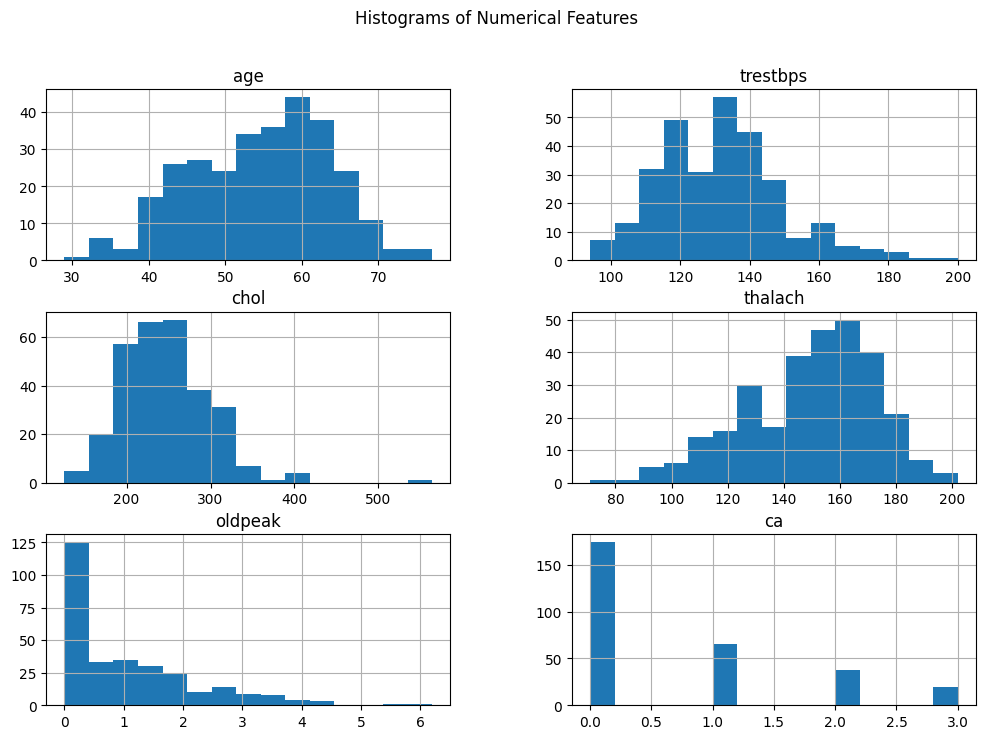

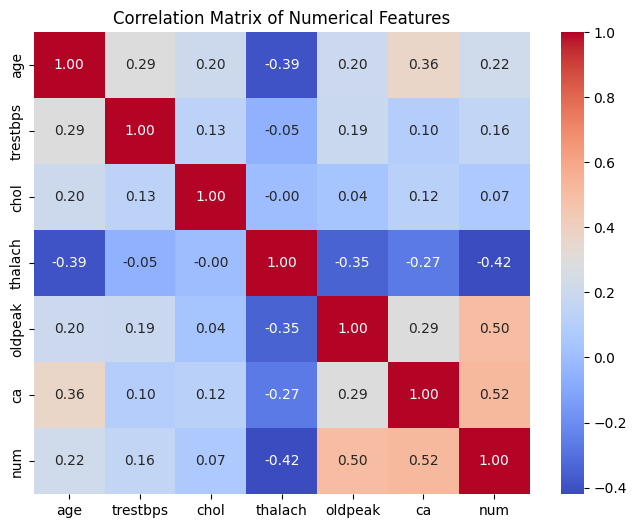

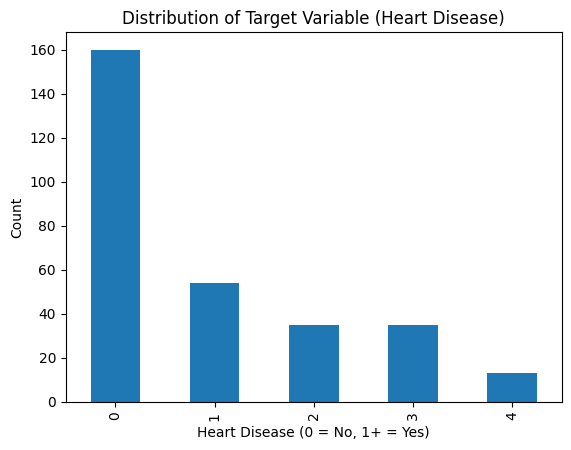

In [4]:
# Preview the first few rows
print(df_clean.head())

# Check data types
print(df_clean.dtypes)

# All the numerical features
numerical_features = [ "age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num" ]
X_numerical = df_clean[numerical_features]
X_unsupervised = X_numerical.drop(columns="num")

# We dont want the labeldata for the unsupervised learning.
X_unsupervised.hist(bins=15, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(X_numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

df_clean["num"].value_counts().plot(kind="bar")
plt.title("Distribution of Target Variable (Heart Disease)")
plt.xlabel("Heart Disease (0 = No, 1+ = Yes)")
plt.ylabel("Count")
plt.show()

## 3. Unsupervised Learning: PCA + GMM

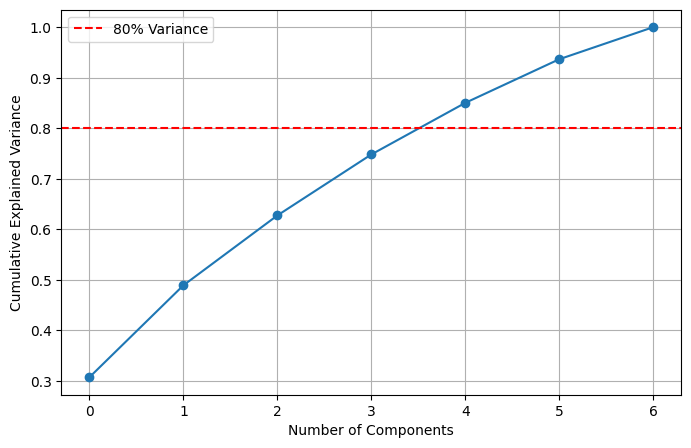

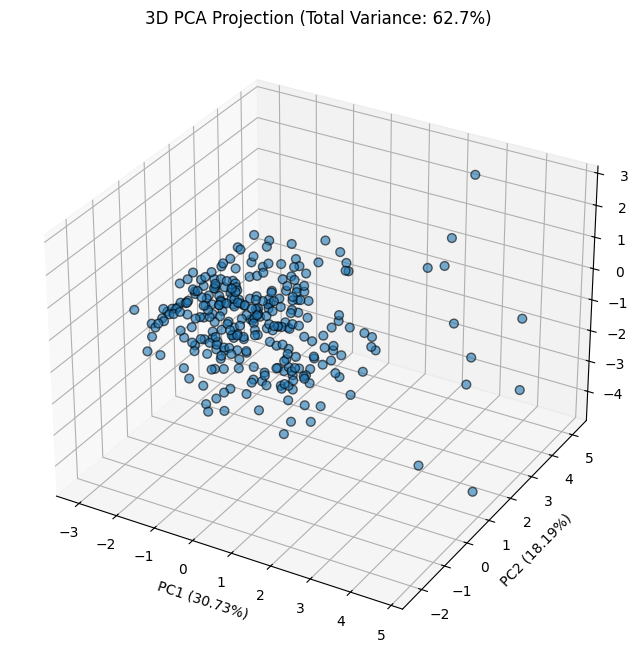

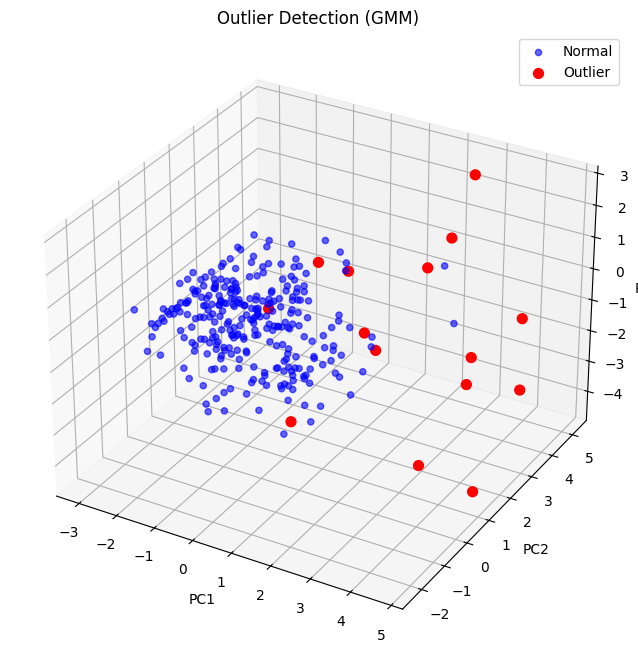


Outlier Distribution:
is_outlier
0    282
1     15
Name: count, dtype: int64

Outlier Percentage: 5.05%

Outlier Statistics:
             age    trestbps        chol     thalach    oldpeak         ca  \
count  15.000000   15.000000   15.000000   15.000000  15.000000  15.000000   
mean   58.066667  148.133333  305.200000  146.933333   2.506667   1.133333   
std    11.603366   30.647458  103.606536   28.059800   2.091980   1.302013   
min    29.000000  102.000000  164.000000  109.000000   0.000000   0.000000   
25%    55.000000  127.500000  243.500000  125.000000   0.400000   0.000000   
50%    59.000000  140.000000  304.000000  145.000000   2.400000   1.000000   
75%    64.000000  174.000000  326.500000  160.000000   4.000000   2.500000   
max    77.000000  200.000000  564.000000  202.000000   6.200000   3.000000   

       is_outlier  
count        15.0  
mean          1.0  
std           0.0  
min           1.0  
25%           1.0  
50%           1.0  
75%           1.0  
max        

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# 1. Data Preparation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

# 2. PCA Analysis
# Plot explained variance
pca = PCA().fit(X_scaled)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
plt.grid(True)
plt.legend()
plt.show()

# 3. Dimensionality Reduction (3 components)
k = 3  # Using 3 components as they explain >80% variance
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_scaled)

# 4. Visualize PCA Projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
    alpha=0.6, 
    edgecolor='k',
    s=40
)
ax.set_xlabel("PC1 (%.2f%%)" % (pca.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC2 (%.2f%%)" % (pca.explained_variance_ratio_[1]*100))
ax.set_zlabel("PC3 (%.2f%%)" % (pca.explained_variance_ratio_[2]*100))
ax.set_title("3D PCA Projection (Total Variance: %.1f%%)" % 
             (sum(pca.explained_variance_ratio_)*100))
plt.show()

# 5. Outlier Detection with GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_pca)

# Get probabilities and identify outliers
log_probs = gmm.score_samples(X_pca)
threshold = np.quantile(log_probs, 0.05)  # Bottom 5% as outliers
outliers = log_probs < threshold

# 6. Visualize Outliers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal points
ax.scatter(
    X_pca[~outliers, 0], X_pca[~outliers, 1], X_pca[~outliers, 2],
    c='blue', alpha=0.6, label='Normal'
)

# Plot outliers
ax.scatter(
    X_pca[outliers, 0], X_pca[outliers, 1], X_pca[outliers, 2],
    c='red', alpha=1, label='Outlier', s=50
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Outlier Detection (GMM)")
ax.legend()
plt.show()

# 7. Create Outlier Feature
# Convert numpy array to pandas Series with original index
outlier_feature = pd.Series(outliers, index=X_unsupervised.index, name='is_outlier')

# Add to original dataset (ensuring no SettingWithCopyWarning)
X_unsupervised = X_unsupervised.copy()
X_unsupervised['is_outlier'] = outlier_feature.astype(int)

# 8. Analyze Results
print("\nOutlier Distribution:")
print(X_unsupervised['is_outlier'].value_counts())
print(f"\nOutlier Percentage: {outliers.mean():.2%}")

print("\nOutlier Statistics:")
print(X_unsupervised[X_unsupervised['is_outlier'] == 1].describe())

print("\nNormal Point Statistics:")
print(X_unsupervised[X_unsupervised['is_outlier'] == 0].describe())

In [ ]:
df_clean = df_clean.copy()
df_clean['is_outlier'] = X_unsupervised['is_outlier']

categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
df_final = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

X = df_final.drop(columns=["num"])
y = (df_final["num"] > 0).astype(int) 
""" 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nFinal Feature Set Shape:", X.shape)
print("Train/Test Split Sizes:", X_train.shape, X_test.shape)
"""


Final Feature Set Shape: (297, 19)
Train/Test Split Sizes: (237, 19) (60, 19)


## 4. Supervised Learning: SVM, Random Forest, KNN

## 5. Feature Selection & Feature Importance

## 6. Evaluation: Accuracy, F1, Confusion Matrix


## 7. Conclusions & Discussion